# Analysis of 10x Visium human breast cancer slice

In this tutorial, we demonstrate SpaSRL on the analysis of 10x Visium human breast cancer (block A section 1) slice including

* Spatial expression enhancement
* Self-representation learning
* Spatial domain identification
* Spatial domain annotation
* Finding differentially expressed genes

The dataset is available at [10x genomics website](https://www.10xgenomics.com/resources/datasets) (Spatial Gene Expression >> Visium Demonstration (v1 Chemistry) >> Space Ranger 1.0.0 >> Human Breast Cancer (Block A Section 1)).

In [1]:
import numpy as np
import pandas as pd
import scanpy as sc
import matplotlib.pyplot as plt
import SpaSRL

%matplotlib inline

## Data loading and preprocessing

We load the dataset and find top 2000 highly variable genes.

In [2]:
adata = sc.read_visium('./data/Human Breast Cancer (Block A Section 1)/')
adata.var_names_make_unique()
adata

Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.


AnnData object with n_obs × n_vars = 3813 × 33538
    obs: 'in_tissue', 'array_row', 'array_col'
    var: 'gene_ids', 'feature_types', 'genome'
    uns: 'spatial'
    obsm: 'spatial'

In [3]:
sc.pp.highly_variable_genes(adata, n_top_genes=2000, flavor='seurat_v3')

## Spatial expression enhancement

We perform spatial expression enhancement to aggregate expression from spatial neighbors.

In [4]:
SpaSRL.spatial_enhancement(adata)

## Self-representation learning

We perform self-representation learning on the enhanced data.

In [5]:
SpaSRL.run_SRL(adata, n_neighbors=30, n_pcs=15)

 21%|██████▏                       | 104/500 [00:09<00:37, 10.62it/s, relChg: 3.851e-05, recErr: 9.747e-06, converged!]


## Spatial domain identification

We identify spatial domians using the representation matrix.

In [6]:
sc.tl.leiden(adata, resolution=0.65, neighbors_key='representation')
SpaSRL.refine_spatial_domains(adata, domain_key='leiden')

C:\ProgramData\Anaconda3\lib\site-packages\anndata\_core\anndata.py:1220: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Reordering categories will always return a new Categorical object.
  c.reorder_categories(natsorted(c.categories), inplace=True)
... storing 'feature_types' as categorical
C:\ProgramData\Anaconda3\lib\site-packages\anndata\_core\anndata.py:1220: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Reordering categories will always return a new Categorical object.
  c.reorder_categories(natsorted(c.categories), inplace=True)
... storing 'genome' as categorical


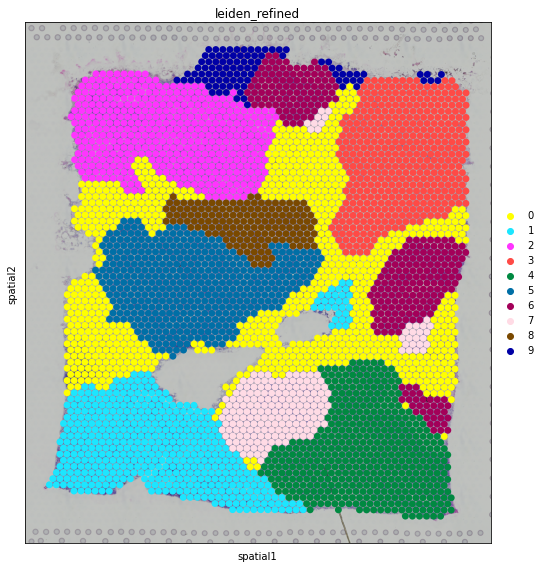

In [7]:
fig, axs = plt.subplots(figsize=(8, 8))

sc.pl.spatial(
    adata,
    img_key='hires',
    color='leiden_refined',
    size=1.5,
    palette=sc.pl.palettes.default_102,
    legend_loc='right margin',
    show=False,
    ax=axs,
)

plt.tight_layout()

## Spatial domain annotation

We annotate the spatial domains based on the pathologist annotation from [Fu, H. et al.](https://www.biorxiv.org/content/10.1101/2021.06.15.448542v2)

In [8]:
map_dict = {
    '0': 'Surrounding tumor',
    '1': 'Invasive',
    '2': 'Invasive',
    '3': 'Healthy',
    '4': 'Invasive',
    '5': 'Tumor',
    '6': 'Tumor',
    '7': 'Tumor',
    '8': 'Invasive',
    '9': 'Surrounding tumor',
}

In [9]:
adata.obs['annotation'] = pd.Categorical(
    adata.obs['leiden_refined'].map(map_dict),
    categories=['Invasive', 'Tumor', 'Surrounding tumor', 'Healthy']
)

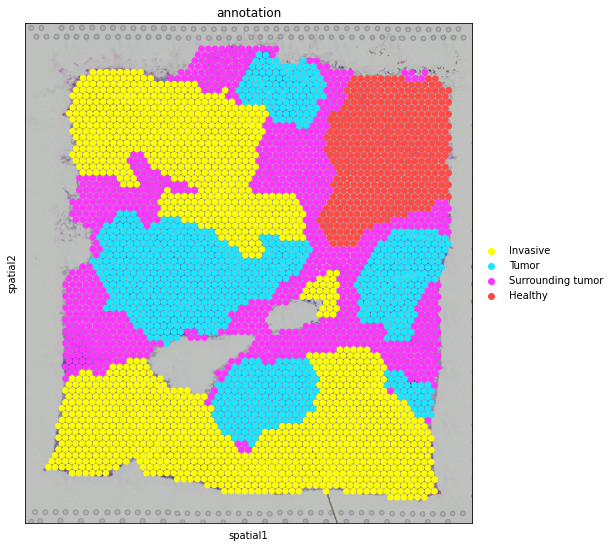

In [10]:
fig, axs = plt.subplots(figsize=(8, 8))

sc.pl.spatial(
    adata,
    img_key='hires',
    color='annotation',
    size=1.5,
    palette=sc.pl.palettes.default_102,
    legend_loc='right margin',
    show=False,
    ax=axs,
)

plt.tight_layout()

## Finding differentially expressed genes

We find the differentially expressed (DE) genes across identified domains and show their expression patterns in spatial coordinates.

In [11]:
sc.tl.rank_genes_groups(adata, groupby='leiden_refined', use_raw=False, layer='counts', method='t-test')

In [12]:
DE_genes = pd.DataFrame(adata.uns['rank_genes_groups']['names']).iloc[:10,:]
DE_genes

,0,1,2,3,4,5,6,7,8,9
0,IGLC2,CXCL14,COX6C,ACKR1,CRISP3,CPB1,MGP,S100G,LINC00645,ALB
1,IGHG1,CCND1,SLC39A6,CCL21,SLITRK6,HLA-B,S100G,HLA-B,MUC5B,MGP
2,IGLC3,DEGS1,SNCG,CLDN5,S100A13,IL6ST,DSP,HLA-A,IGFBP2,PGC
3,IGKC,CPNE7,WFDC2,CHRDL1,SERHL2,ADIRF,TFF3,AC087379.2,PVALB,MT-ATP8
4,C3,DEGS2,MT-ND1,MMRN1,IGFBP5,HLA-C,MT-CO2,IFI6,ZNF703,HBA2
5,IGHG3,PSMB4,CSTA,ADAM33,CALML5,CFB,ACADSB,IFI27,SLC39A6,MT-ND2
6,SFRP4,MUC1,MCCD1,TNXB,S100A16,HLA-A,MT-CO1,IFT122,EXOC2,S100A7
7,JCHAIN,S100A11,MT-CO1,TTN,KRT8,COX6C,TFF1,BST2,COLEC12,HBB
8,IGHM,GFRA1,RAB11FIP1,INMT,S100A11,H2AFJ,IGFBP5,ISG15,SLC30A8,CCL7
9,IGHG2,AGR2,UGCG,CCL19,NUPR1,FCGRT,LDHA,LGALS3BP,PLXNB2,STEAP4


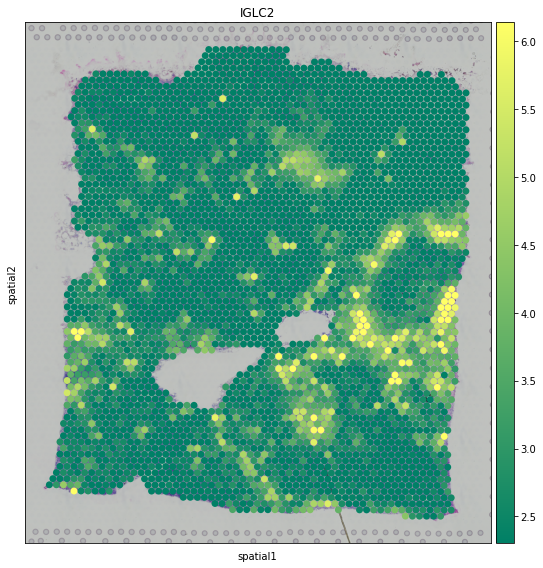

In [13]:
fig, axs = plt.subplots(figsize=(8, 8))

sc.pl.spatial(
    adata,
    img_key='hires',
    color=DE_genes.iloc[0,0],
    layer='log1p',
    size=1.5,
    cmap='summer',
    vmin='p50',
    vmax='p99',
    show=False,
    ax=axs,
)

plt.tight_layout()

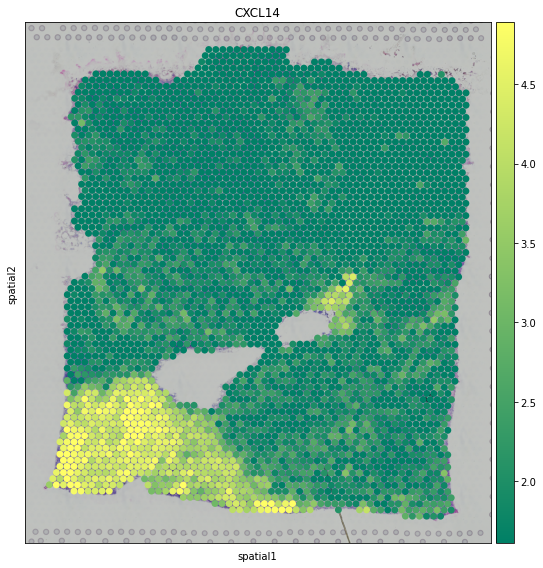

In [14]:
fig, axs = plt.subplots(figsize=(8, 8))

sc.pl.spatial(
    adata,
    img_key='hires',
    color=DE_genes.iloc[0,1],
    layer='log1p',
    size=1.5,
    cmap='summer',
    vmin='p50',
    vmax='p99',
    show=False,
    ax=axs,
)

plt.tight_layout()